In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import seaborn as sns
import numpy as np
import anndata

%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH = pathlib.Path(
    "/storage/groups/ml01/datasets/raw/20201214_SquidpyData_giovanni.palla/merfish"
)
DATA_PATH = ""
counts = pd.read_csv(BASE_PATH / "Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv")

In [3]:
metadata = counts[counts.columns[0:9].values].copy()
metadata.reset_index(inplace=True, drop=True)
counts_g = counts[counts.columns[9:].values].copy()
counts_g.reset_index(inplace=True, drop=True)

In [4]:
import scipy

genes = counts_g.columns.values

counts_g_sparse = scipy.sparse.csr_matrix(counts_g.fillna(0).to_numpy())
counts_g_sparse.eliminate_zeros()
adata = anndata.AnnData(counts_g_sparse, obs=metadata)
adata.var_names = genes

spatial = adata.obs[["Centroid_X", "Centroid_Y"]].to_numpy()
adata.obsm["spatial"] = spatial

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata.obs.Bregma = adata.obs.Bregma * 100

In [6]:
adata.obs.Animal_ID.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 16, 17, 18, 19, 12, 13,
       14, 15, 20, 21, 22, 23, 24, 34, 35, 36, 31, 32, 33, 25, 26, 27, 28,
       29, 30])

In [7]:
adata_filt = adata[adata.obs.Animal_ID == 1].copy()

In [8]:
adata_filt.obs.Bregma.unique()[::-1]

array([-29., -24., -19., -14.,  -9.,  -4.,   1.,   6.,  11.,  16.,  21.,
        26.])

In [18]:
adata_list = []
spatial_list = []
for i in adata_filt.obs.Bregma.unique()[::-1]:
    ad_filt = adata_filt[adata_filt.obs.Bregma == i].copy()
    adata_list.append(ad_filt)
    spatial_filt = ad_filt.obsm["spatial"].copy()
    spatial_filt = (spatial_filt - spatial_filt.min(0)) / spatial_filt.ptp(0)
    spatial_list.append(spatial_filt)

In [19]:
adata_total = adata_list[0].concatenate([ad for ad in adata_list[1:]])
adata_total.obsm["spatial"] = np.concatenate(spatial_list, axis=0)
spatial_total = adata_total.obsm["spatial"].copy()
# adata_total.obs["Bregma"] = adata_total.obs["Bregma"] * -1

In [20]:
adata_total.obsm["spatial3d"] = np.column_stack(
    [spatial_total, adata_total.obs["Bregma"].values.T]
)

In [21]:
adata.obs

Cell_ID  Animal_ID Animal_sex Behavior  \
0        6749ccb4-2ed1-4029-968f-820a287f43c8          1     Female    Naive   
1        6cac74bd-4ea7-4701-8701-42563cc65eb8          1     Female    Naive   
2        9f29bd57-16a5-4b26-b9f5-37598809da9e          1     Female    Naive   
3        d7eb4e0b-276e-47e3-a55c-0b033180a2fe          1     Female    Naive   
4        54434f3a-eba9-4aec-af35-c9d317ffa1d5          1     Female    Naive   
...                                       ...        ...        ...      ...   
1027843  eaaf93ba-75b1-40cd-af08-a4d803511354         30       Male   Mating   
1027844  bb9caf59-d960-452e-a9fd-9238ce5e44ca         30       Male   Mating   
1027845  2f45d61d-3a80-470b-8cb8-251a2c8d2e59         30       Male   Mating   
1027846  180ae0ff-9817-48b9-8d34-b374bda6e316         30       Male   Mating   
1027847  83463d3a-29c5-40c3-b762-ffc3b7a11ad3         30       Male   Mating   

         Bregma   Centroid_X   Centroid_Y  Cell_class Neuron_cluster_ID  
0          26.0 -3211.562145  2608.541476   Astrocyte               NaN  
1          26.0 -3207.923151  2621.795437  Inhibitory               I-5  
2          26.0 -3209.578004  2633.153494  Inhibitory               I-6  
3          26.0 -3203.853515  2756.045983  Inhibitory               I-5  
4          26.0 -3202.682705  2608.803635  Inhibitory               I-9  
...         ...          ...          ...         ...               ...  
1027843    11.0  2732.438894 -2322.578167   Ambiguous               NaN  
1027844    11.0  2732.665807 -2120.226450   Ambiguous               NaN  
1027845    11.0  2826.247461 -2308.947366   Ambiguous               NaN  
1027846    11.0  2900.963778 -2174.600160  Inhibitory               I-2  
1027847    11.0  2817.020857 -1716.243777   Ambiguous               NaN  

[1027848 rows x 9 columns]

... storing 'Animal_sex' as categorical
... storing 'Behavior' as categorical
... storing 'Cell_class' as categorical
... storing 'Neuron_cluster_ID' as categorical


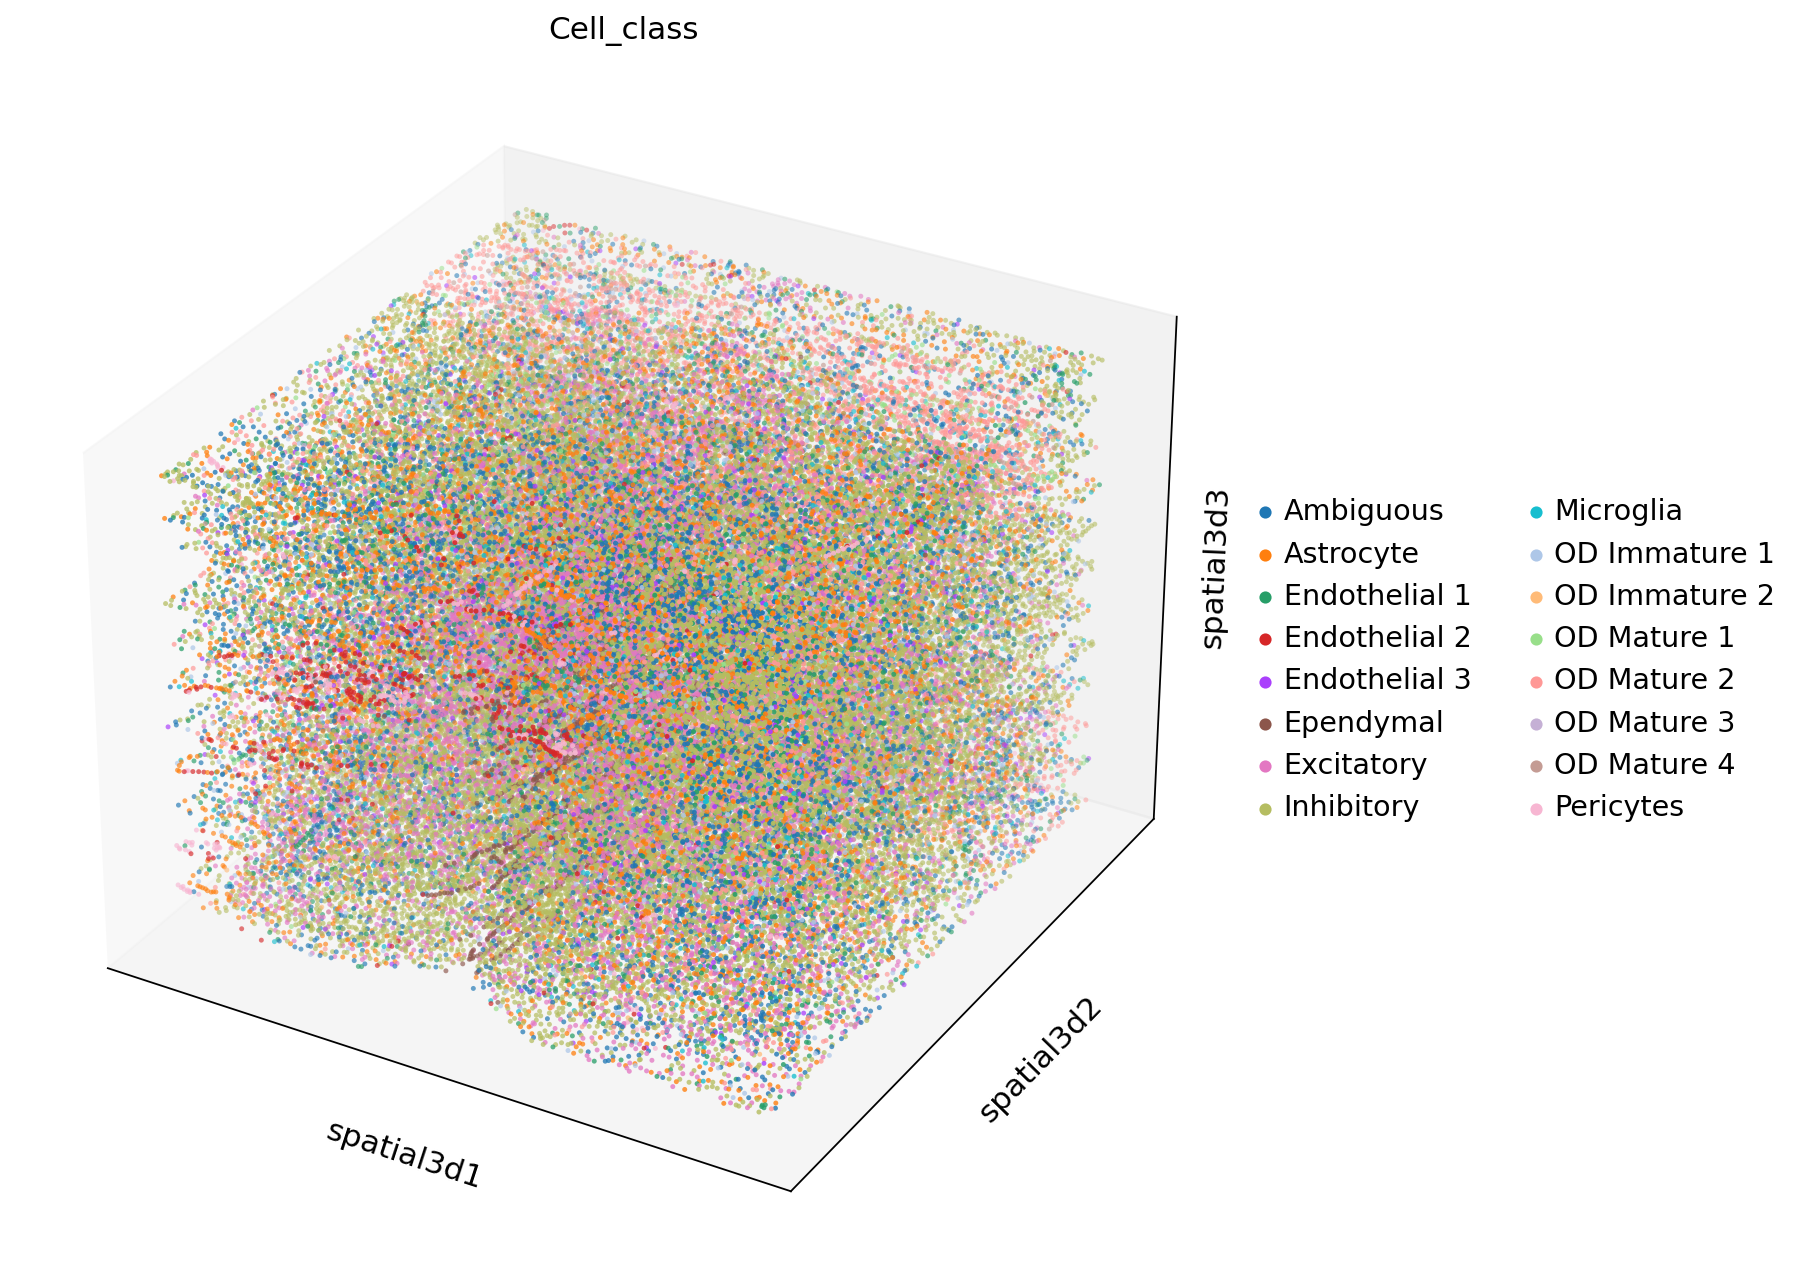

In [22]:
sc.set_figure_params(figsize=(10, 10))
sc.pl.embedding(
    adata_total, basis="spatial3d", projection="3d", color="Cell_class", size=100
)

In [23]:
adata_total.obs.Bregma.unique()

array([-29., -24., -19., -14.,  -9.,  -4.,   1.,   6.,  11.,  16.,  21.,
        26.])

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


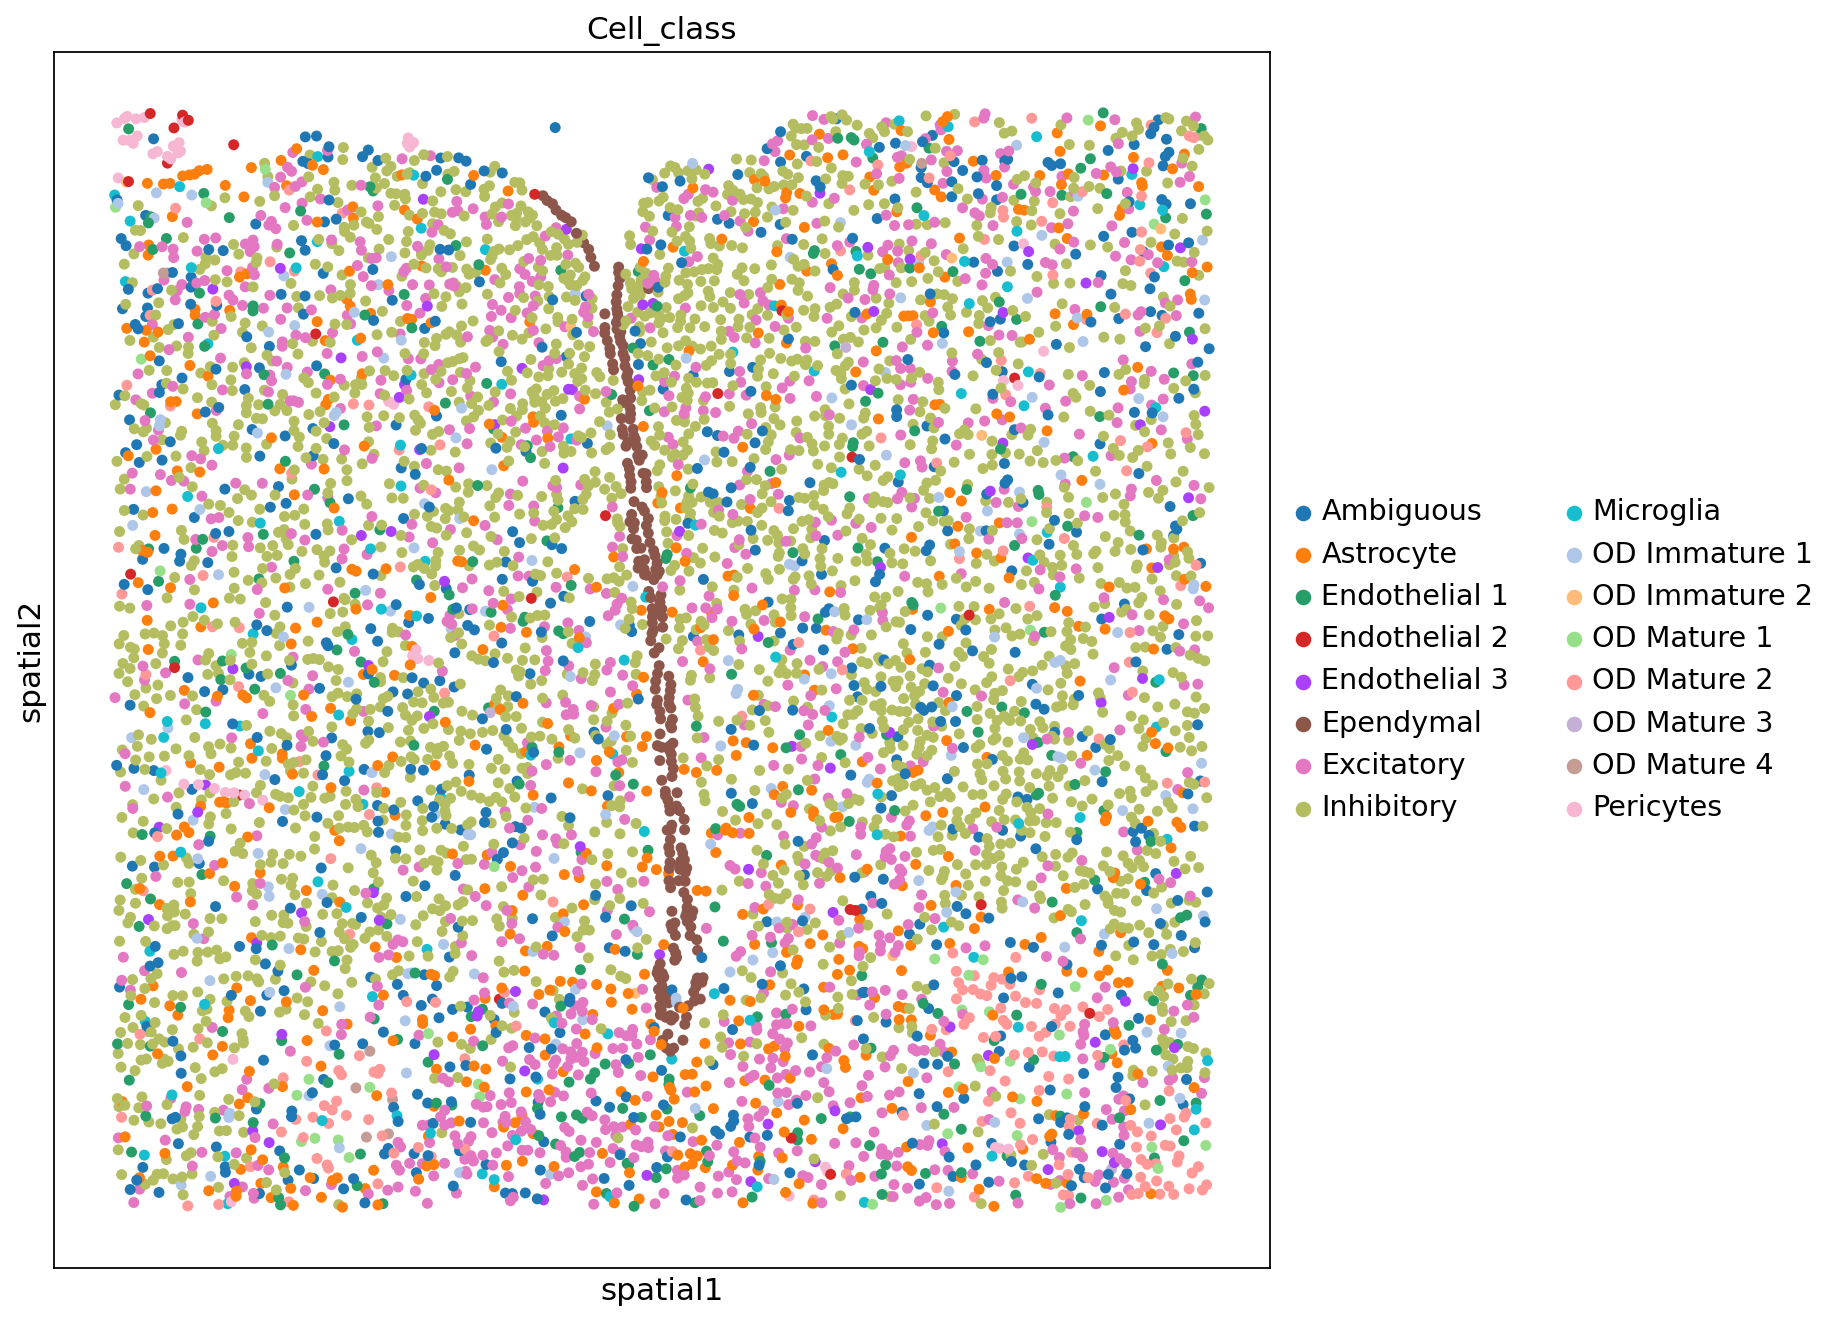

In [24]:
sc.pl.spatial(
    adata_total[adata_total.obs.Bregma == -19], color="Cell_class", spot_size=0.01
)

In [26]:
adata_total.write(
    "/storage/groups/ml01/datasets/raw/20201214_SquidpyData_giovanni.palla/tutorial_data/merfish3d.h5ad"
)

In [27]:
adata_total

AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors'
    obsm: 'spatial', 'spatial3d'

In [16]:
import squidpy as sq

In [17]:
sq.gr.spatial_neighbors(adata_total, spatial_key="spatial3d")

In [49]:
adata_total.obsp

PairwiseArrays with keys: spatial_connectivities, spatial_distances

In [68]:
sq.gr.nhood_enrichment(
    adata_total,
    cluster_key="Cell_class",
)

  0%|          | 0/1000 [00:00<?, ?/s]

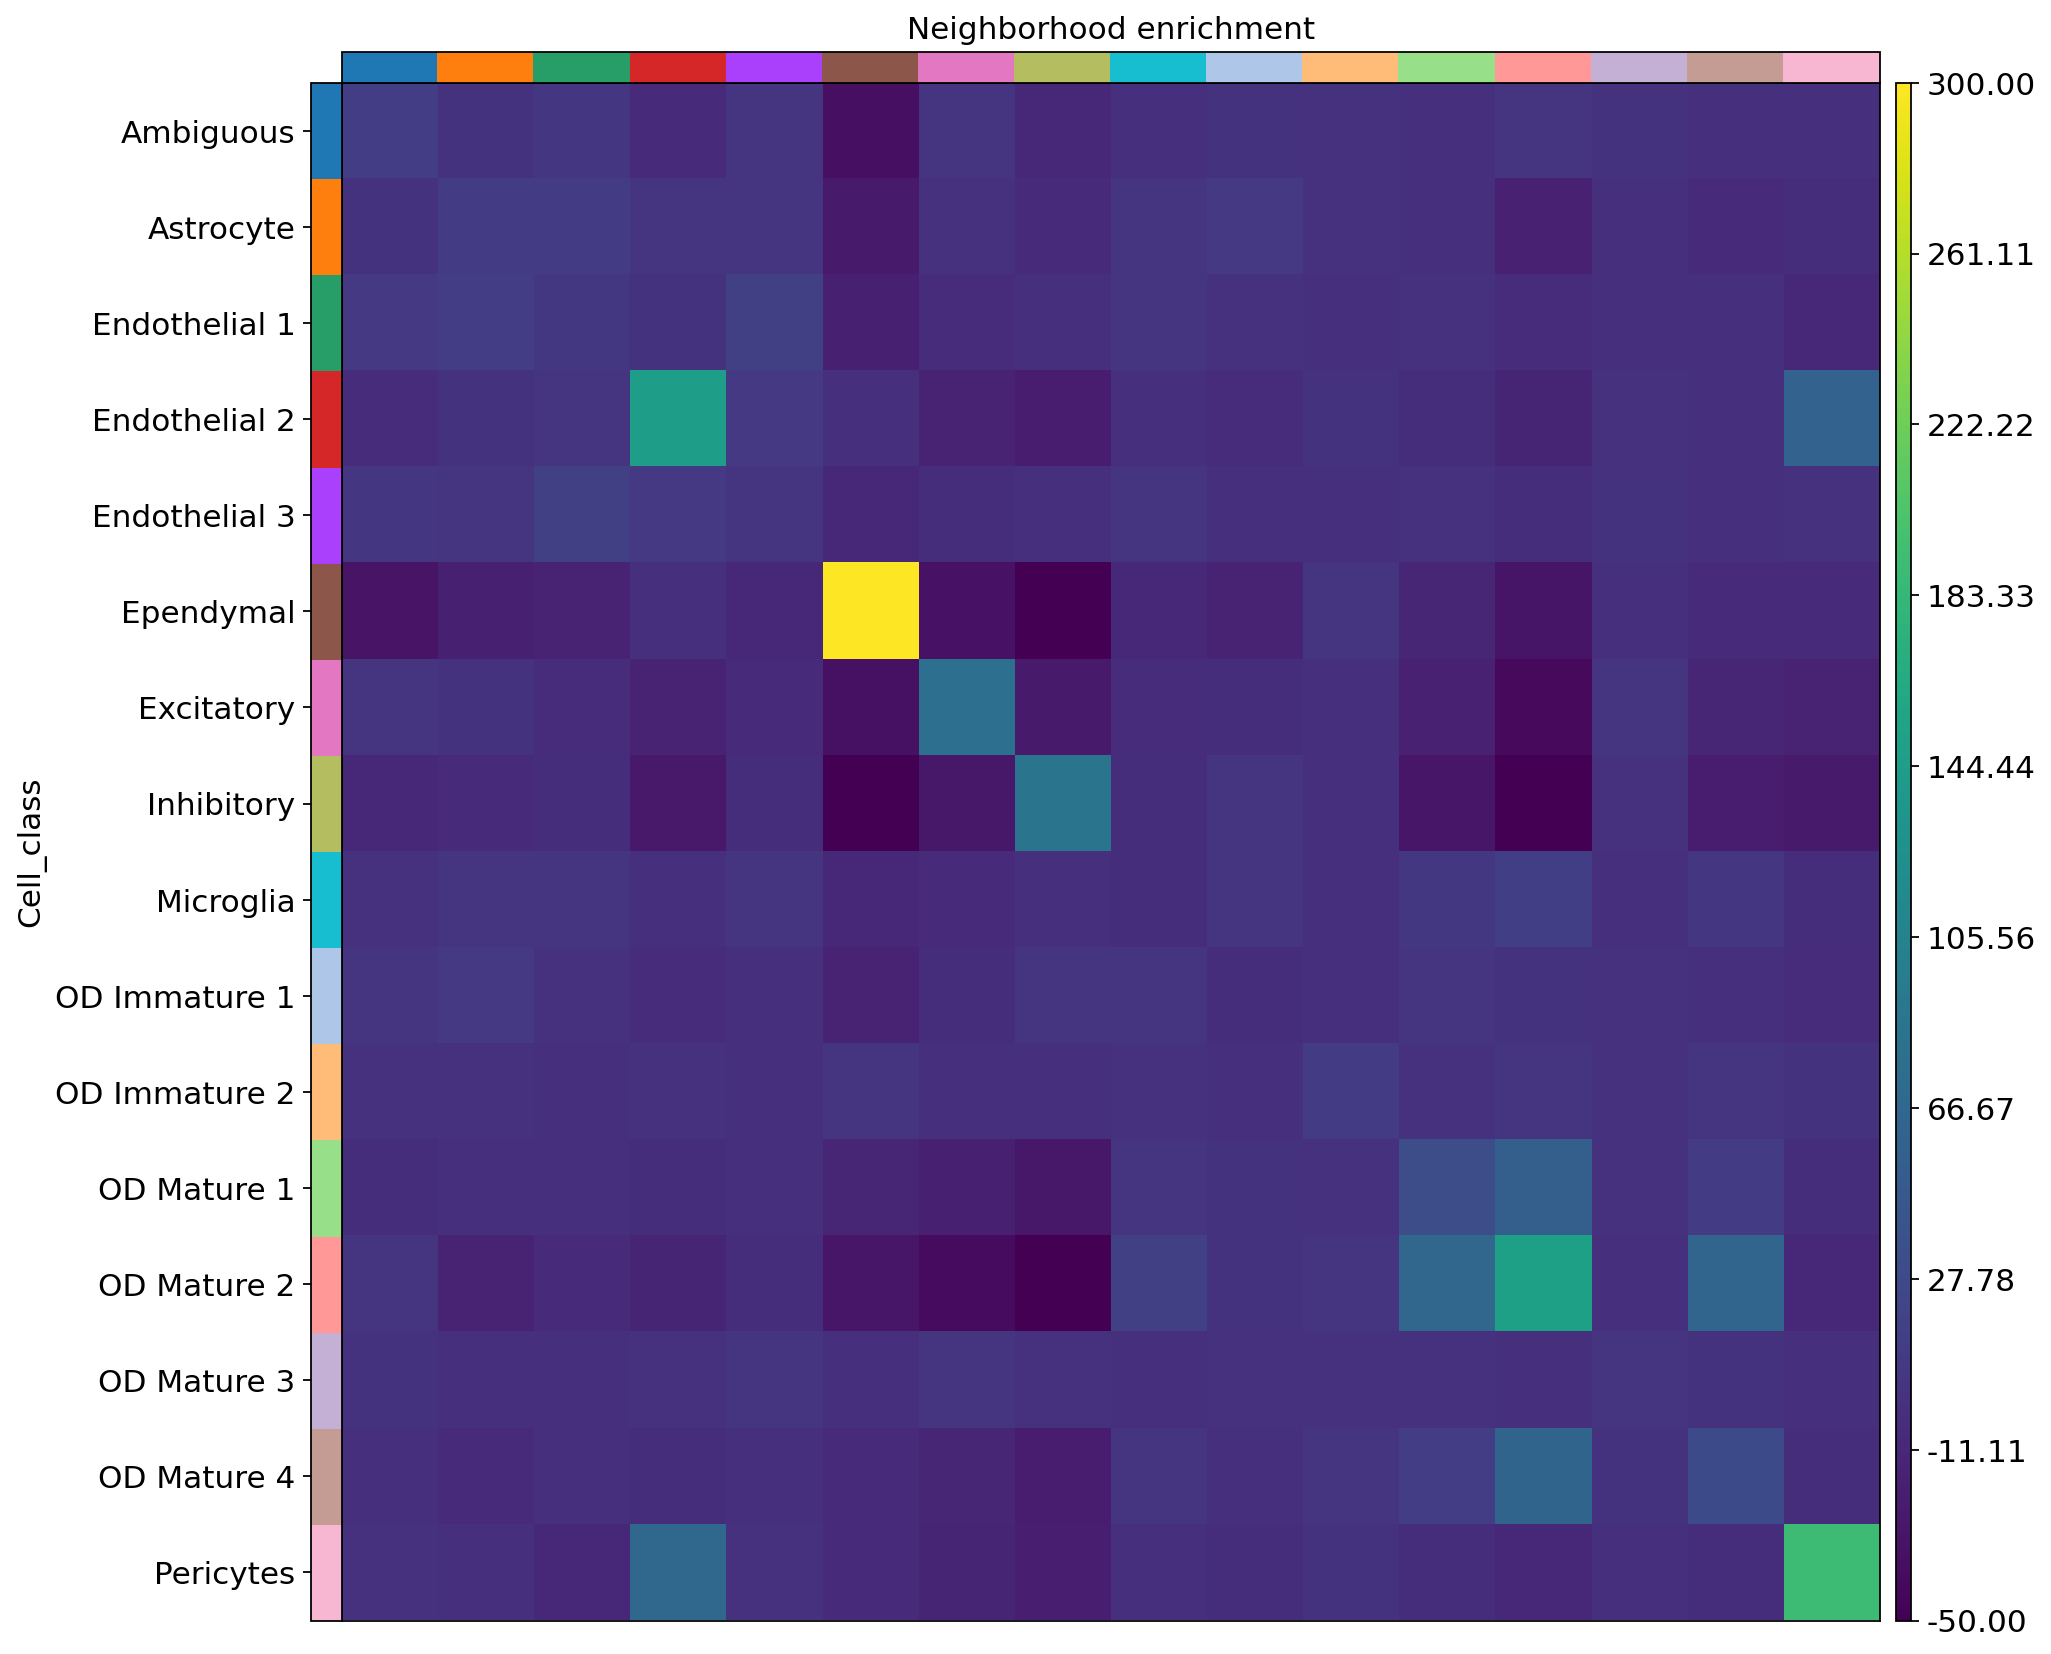

In [69]:
sq.pl.nhood_enrichment(adata_total, cluster_key="Cell_class", vmin=-50, vmax=300)

In [70]:
adata.obs.Cell_class.unique()

['Astrocyte', 'Inhibitory', 'OD Mature 2', 'Endothelial 1', 'Ambiguous', ..., 'Endothelial 3', 'OD Mature 4', 'OD Immature 2', 'OD Mature 3', 'Ependymal']
Length: 16
Categories (16, object): ['Astrocyte', 'Inhibitory', 'OD Mature 2', 'Endothelial 1', ..., 'OD Mature 4', 'OD Immature 2', 'OD Mature 3', 'Ependymal']

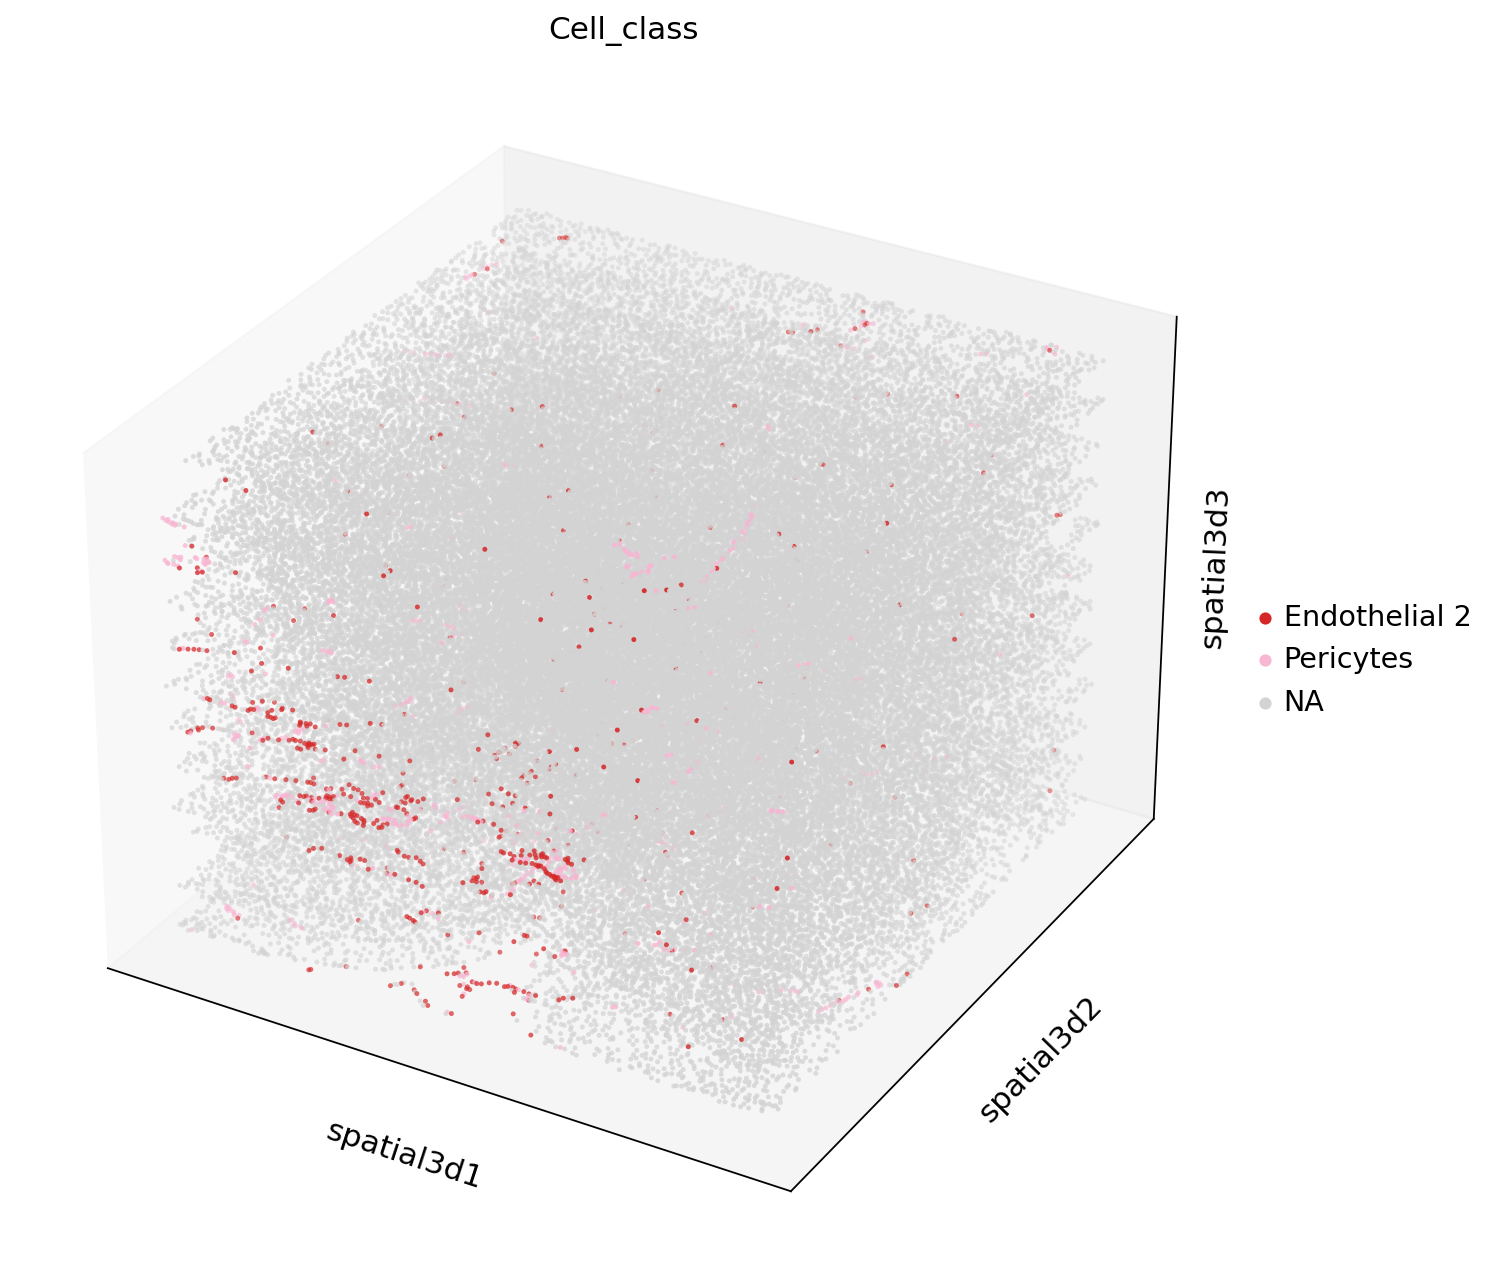

In [71]:
sc.pl.embedding(
    adata_total,
    basis="spatial3d",
    projection="3d",
    color="Cell_class",
    groups=["Pericytes", "Endothelial 2"],
)

In [60]:
adata_total.obs.Bregma.unique()

array([ 29.,  24.,  19.,  14.,   9.,   4.,  -1.,  -6., -11., -16., -21.,
       -26.])

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


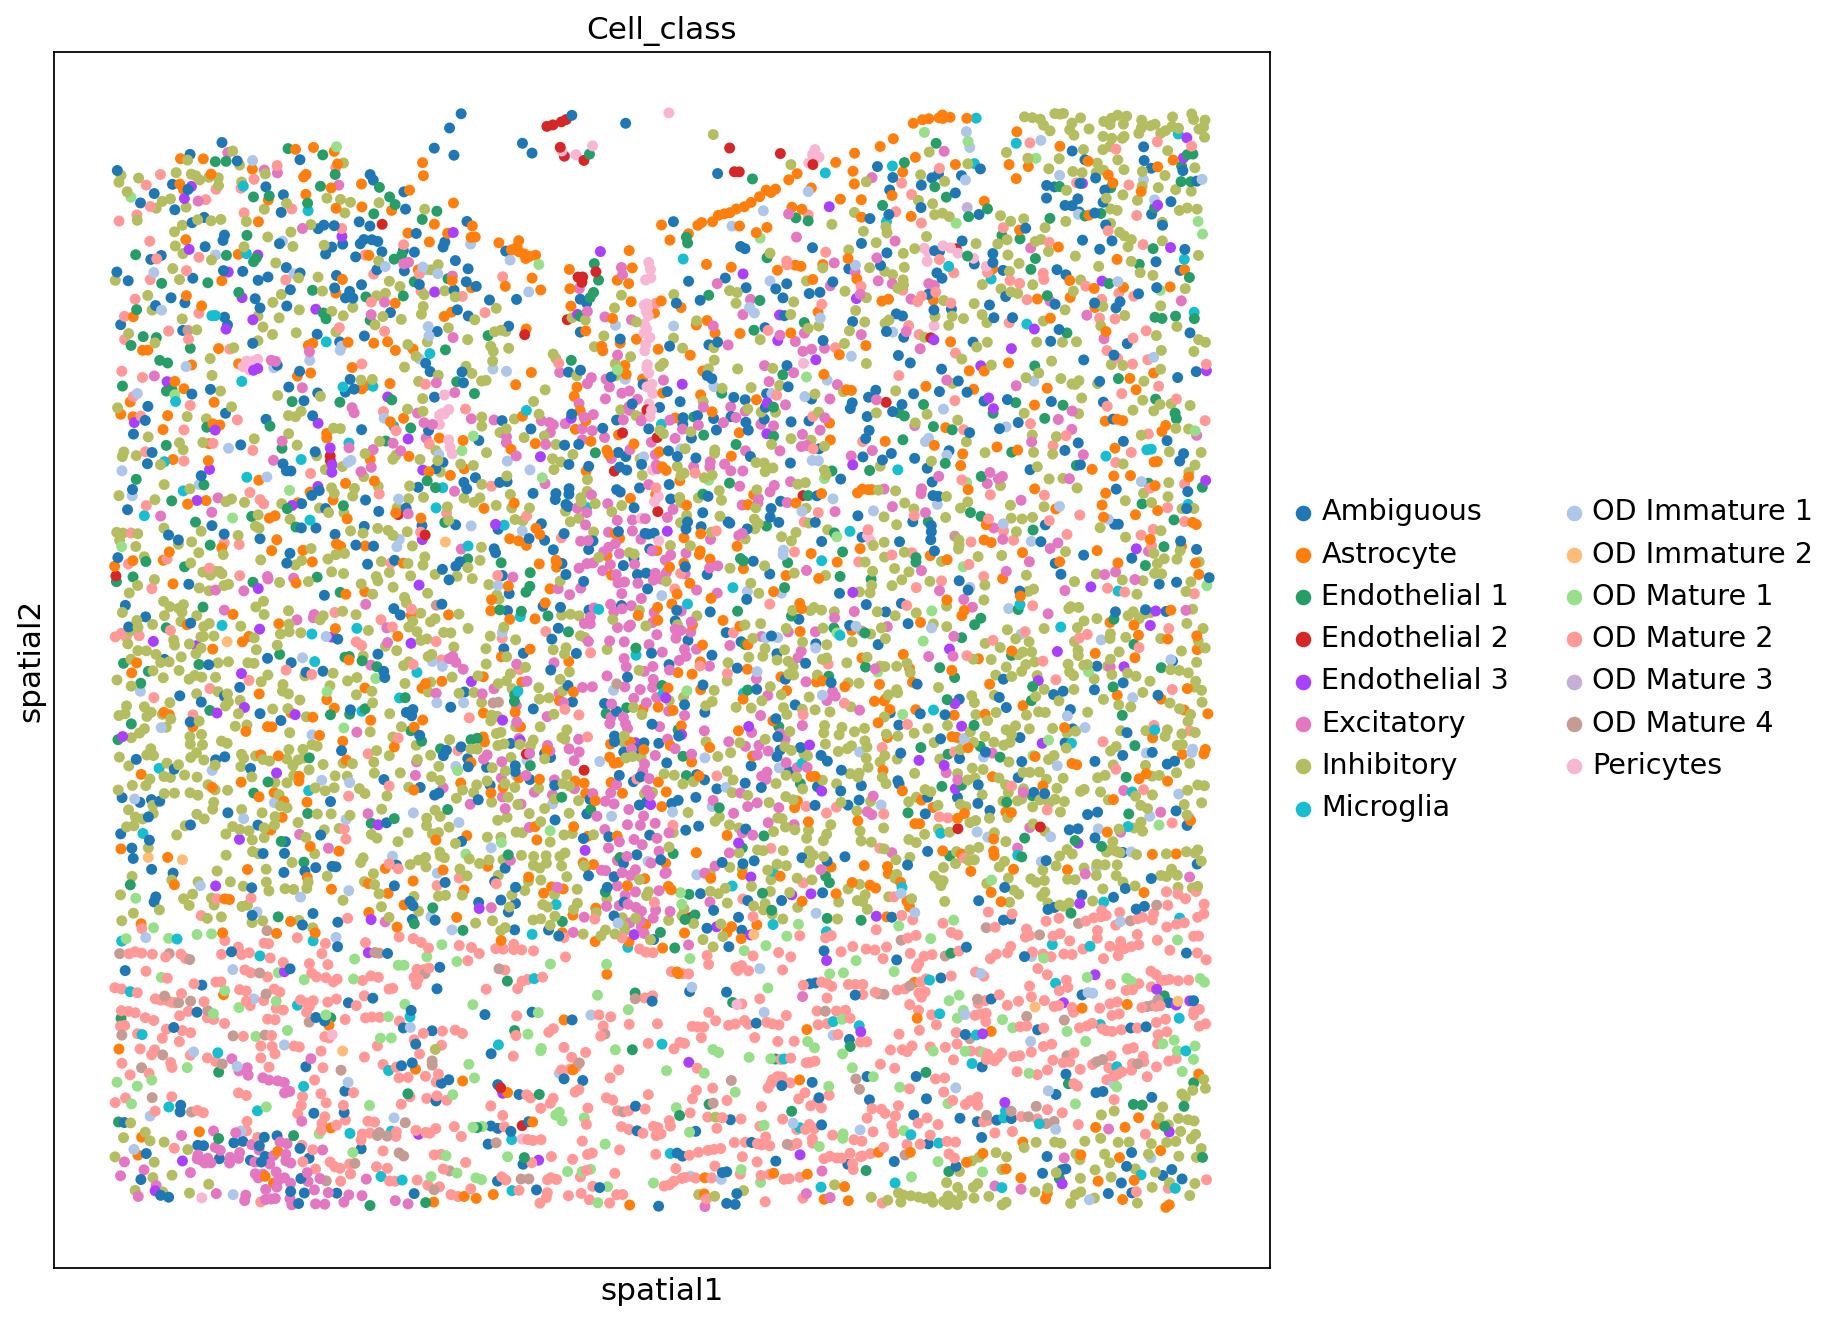

In [64]:
sc.pl.spatial(
    adata_total[adata_total.obs.Bregma == -16], color="Cell_class", spot_size=0.01
)

In [145]:
spa_list = []
for b in adata_filt.obs.Bregma.unique():
    spatial = adata_filt[adata_filt.obs.Bregma == b].obsm["spatial"].copy()
    spatial = (spatial - spatial.min(0)) / spatial.ptp(0)
    spa_list.append(spatial)

In [146]:
spatial = np.concatenate(spa_list, axis=0)

In [147]:
spatial_total = np.column_stack([spatial, adata_filt.obs["Bregma"].values.T])

In [148]:
adata_filt.obsm["spatial3d"] = spatial_total

In [109]:
# spatial3d = adata_filt.obs[["Centroid_X", "Centroid_Y", "Bregma"]].to_numpy()
# adata_filt.obsm["spatial3d"] = spatial3d

In [149]:
adata_filt.obsm["spatial"].min(0)

array([-3752.86775 , -4127.194692])

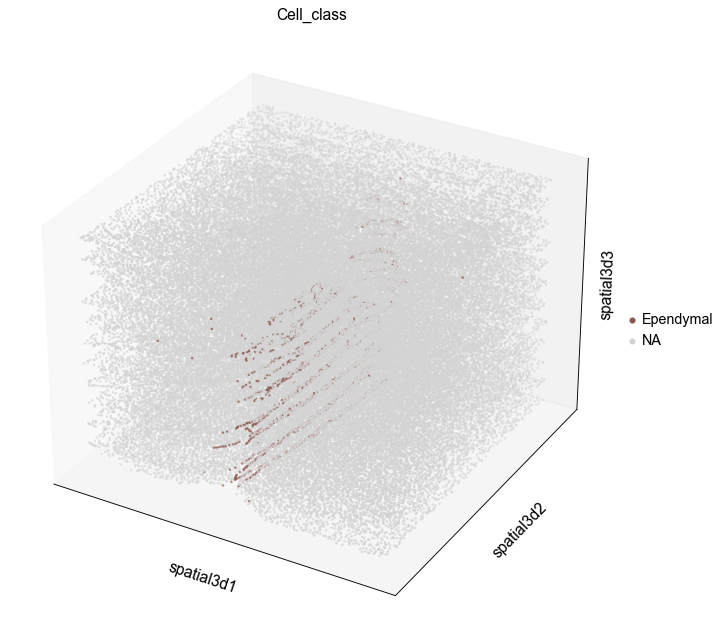

In [151]:
sc.set_figure_params(figsize=(10, 10))
sc.pl.embedding(
    adata_filt,
    basis="spatial3d",
    projection="3d",
    color="Cell_class",
    groups="Ependymal",
)

In [2]:
BASE_PATH = pathlib.Path("/storage/groups/ml01/workspace/anna.schaar/tissue/data/zhang")
DATA_PATH = ""

In [28]:
adata = sc.read(BASE_PATH / DATA_PATH / "preprocessed_zhang.h5ad")

In [33]:
adata

AnnData object with n_obs × n_vars = 280327 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'mouse', 'slice', 'dataset', 'sample'

In [34]:
adata_filt = adata[adata.obs.mouse == "mouse1"].copy()
adata_filt.obsm["spatial"] = adata_filt.obs[["center_x", "center_y"]].to_numpy()

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [35]:
adata_list = []
spatial_list = []
for i in np.sort(adata_filt.obs.slice_id.unique()):
    ad_filt = adata_filt[adata_filt.obs.slice_id == i].copy()
    adata_list.append(ad_filt)
    spatial_filt = ad_filt.obsm["spatial"].copy()
    spatial_filt = (spatial_filt - spatial_filt.min(0)) / spatial_filt.ptp(0)
    spatial_list.append(spatial_filt)

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning

In [36]:
adata_total = adata_list[0].concatenate([ad for ad in adata_list[1:]])
adata_total.obsm["spatial"] = np.concatenate(spatial_list, axis=0)
spatial_total = adata_total.obsm["spatial"].copy()

In [37]:
adata_total.obsm["spatial3d"] = np.column_stack(
    [spatial_total, adata_total.obs["slice_id"].values.T]
)

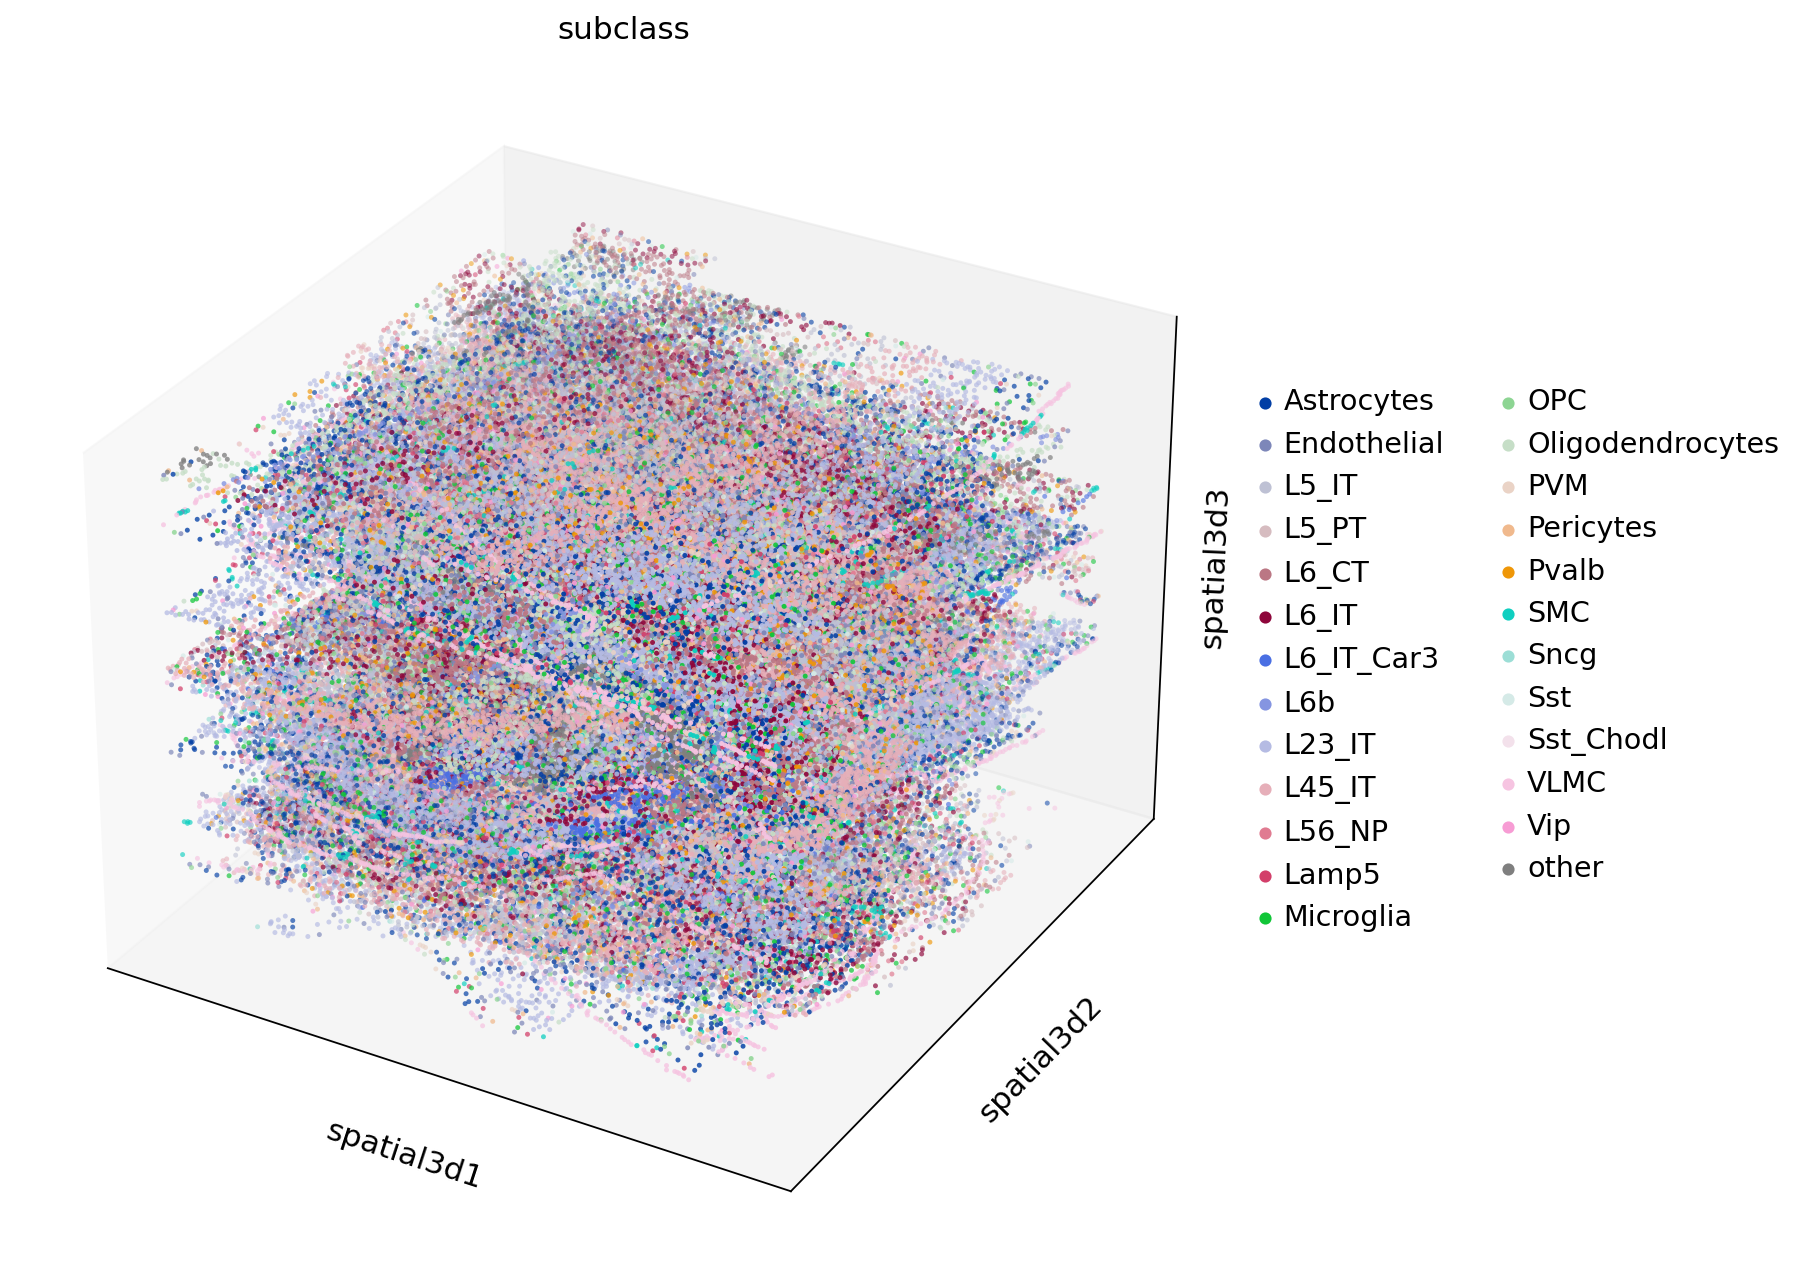

In [43]:
sc.set_figure_params(figsize=(10, 10))
sc.pl.embedding(adata_total, basis="spatial3d", projection="3d", color="subclass")

In [28]:
adata.obsm["spatial"] = adata.obs[["center_x", "center_y"]].to_numpy()
adata.obsm["spatial3d"] = np.stack(
    [
        adata.obsm["spatial"][:, 0].copy(),
        adata.obsm["spatial"][:, 1].copy(),
        adata.obs.slice_idx.values * 10,
    ],
    axis=1,
)

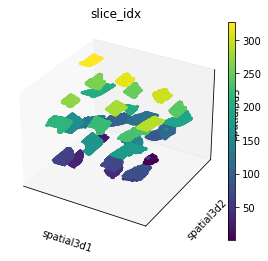

In [29]:
sc.pl.embedding(adata, basis="spatial3d", projection="3d", color="slice_idx")

In [38]:
adata.obs

fovID    fov_x    fov_y       volume  \
point                                                                           
100007228202835962319771548915451072492    432  1262.68 -3752.03   249.515471   
100013893144618144270850756017896167367    381 -1077.16  1294.32  1054.872712   
100018547319796564052034805202079258035    511  3063.35 -2802.39   374.479721   
100019180101435853096549957382098546223    617 -6709.44  1232.53   648.624511   
100023039956376282494130276516336349465    282  5956.17 -3205.97   696.353027   
...                                        ...      ...      ...          ...   
99983502058944096412442332908885097416     267  6156.17 -4405.98  1666.977329   
99985816691327783828891364793469425625     443  -625.24  1713.60  1404.236471   
99987222586328703024576373872583404495      41  4659.91  3032.54   236.124596   
99987465505639073211021560543065098772     386   774.76   913.60  1208.963097   
99991756591196613545069880666241120777      89  3659.91  3432.54   130.928366   

                                            center_x     center_y  \
point                                                               
100007228202835962319771548915451072492  1348.686198 -3589.955255   
100013893144618144270850756017896167367 -1039.703952  1351.852047   
100018547319796564052034805202079258035  3150.850899 -2715.925405   
100019180101435853096549957382098546223 -6657.679404  1287.926499   
100023039956376282494130276516336349465  1005.624232 -2276.225406   
...                                              ...          ...   
99983502058944096412442332908885097416   6227.104943 -4254.154255   
99985816691327783828891364793469425625   -523.775515  1799.600974   
99987222586328703024576373872583404495   4765.904399  3240.331743   
99987465505639073211021560543065098772    890.666985  1069.905972   
99991756591196613545069880666241120777   3847.387896  3589.662245   

                                                slice_id         sample_id  \
point                                                                        
100007228202835962319771548915451072492   mouse1_slice71  dataset1_sample2   
100013893144618144270850756017896167367  mouse1_slice313  dataset1_sample6   
100018547319796564052034805202079258035  mouse1_slice153  dataset1_sample3   
100019180101435853096549957382098546223  mouse1_slice201  dataset1_sample4   
100023039956376282494130276516336349465   mouse1_slice40  dataset1_sample1   
...                                                  ...               ...   
99983502058944096412442332908885097416    mouse1_slice81  dataset1_sample2   
99985816691327783828891364793469425625   mouse1_slice251  dataset1_sample5   
99987222586328703024576373872583404495   mouse1_slice112  dataset1_sample3   
99987465505639073211021560543065098772   mouse1_slice251  dataset1_sample5   
99991756591196613545069880666241120777   mouse1_slice112  dataset1_sample3   

                                            label     subclass    class_label  \
point                                                                           
100007228202835962319771548915451072492      Endo  Endothelial          Other   
100013893144618144270850756017896167367   L6_CT_1        L6_CT  Glutamatergic   
100018547319796564052034805202079258035      Peri    Pericytes          Other   
100019180101435853096549957382098546223   L5_PT_1        L5_PT  Glutamatergic   
100023039956376282494130276516336349465      Endo  Endothelial          Other   
...                                           ...          ...            ...   
99983502058944096412442332908885097416    L5_IT_4        L5_IT  Glutamatergic   
99985816691327783828891364793469425625    Pvalb_4        Pvalb      GABAergic   
99987222586328703024576373872583404495    Astro_1   Astrocytes          Other   
99987465505639073211021560543065098772    Pvalb_1        Pvalb      GABAergic   
99991756591196613545069880666241120777   L45_IT_4       L45_IT  Glutamatergic   

                    

In [42]:
adata[adata.obs.sample_id == "dataset1_sample2"].obs.slice_id.unique()

['mouse1_slice71', 'mouse1_slice102', 'mouse1_slice81', 'mouse1_slice62', 'mouse1_slice91']
Categories (5, object): ['mouse1_slice71', 'mouse1_slice102', 'mouse1_slice81', 'mouse1_slice62', 'mouse1_slice91']

Trying to set attribute `.uns` of view, copying.


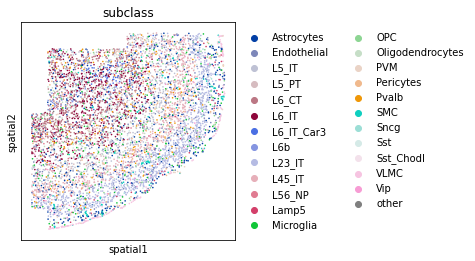

In [37]:
sc.pl.spatial(
    adata[adata.obs.slice_id == "mouse1_slice71"],
    color="subclass",
    spot_size=20,
    img_key=None,
)

In [34]:
adata

AnnData object with n_obs × n_vars = 161525 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'mouse', 'slice', 'dataset', 'sample', 'slice_idx'
    obsm: 'spatial', 'spatial3d'

In [11]:
adata.obs.slice_idx.unique()

array([ 71, 313, 153, 201,  40,   1, 102, 162, 221, 200, 283, 326,  50,
       112, 212, 271, 291,  31, 232,  10, 241, 251, 190,  81,  21, 131,
       122,  62, 180, 170,  91, 301, 260])

In [13]:
adata[adata.obs.slice_idx == 71].shape

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(5749, 254)

/home/icb/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


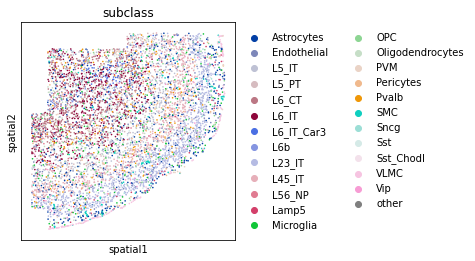

In [36]:
sc.pl.spatial(adata[adata.obs.slice_idx == 71], color="subclass", spot_size=20)

Trying to set attribute `.uns` of view, copying.


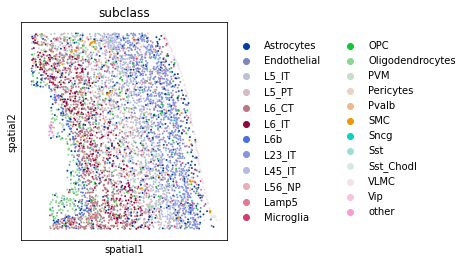

In [25]:
sc.pl.spatial(adata[adata.obs.slice_id=="mouse2_slice160"], color="subclass", spot_size=22)

In [41]:
adata.obsm["spatial"][:, 1].ptp()

11419.092817920075

In [ ]:
adata.obsm["spatial3d"] = adata.obsm["spatial"].copy(), 

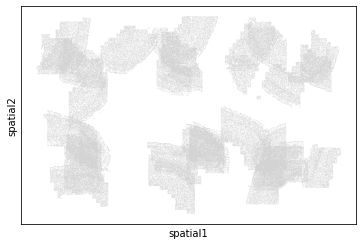

In [27]:
sc.pl.embedding(adata[adata.obs.mouse=="mouse1"],basis="spatial",)

In [5]:
adata = adata[adata.obs.embryo=="embryo1"].copy()

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [6]:
sel = adata.obs["celltype_mapped_refined"].value_counts()[adata.obs["celltype_mapped_refined"].value_counts() > 50].index.values
adata = adata[adata.obs["celltype_mapped_refined"].isin(sel)].copy()

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
adata.obs = adata.obs.drop(columns=['UMAP1', 'UMAP2','uniqueID', 'embryo', 'pos', 'z', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z',])

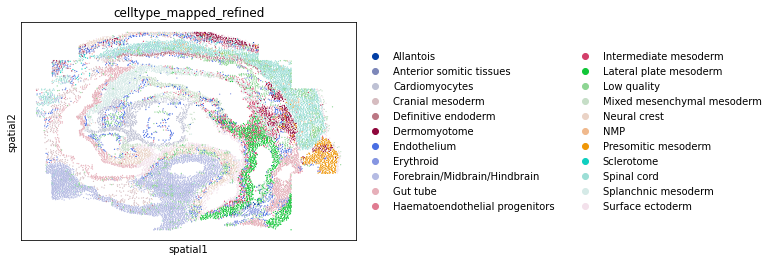

In [8]:
sc.pl.embedding(adata, color="celltype_mapped_refined", basis="spatial")

In [9]:
adata.raw = adata

In [10]:
adata.write("/Users/giovanni.palla/Datasets/tutorial_data/seqfish.h5ad")

In [3]:
adata = sc.read("/Users/giovanni.palla/Datasets/tutorial_data/seqfish.h5ad")
adata

AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined'
    uns: 'celltype_mapped_refined_colors'
    obsm: 'X_umap', 'spatial'